In [31]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('seaborn')

# Branch-and-Bound algorithm for 2-dimensional plane

In [2]:
class Disk:
    
    def __init__(self, center):
        self.center = center
        
    def contains(self, point):
        # True if the distance between the center and the given point <= 1
        return ((self.center[0] - point[0]) ** 2 + (self.center[1] - point[1]) ** 2) ** 0.5 <= 1
    

d = Disk((0, 0))
print(d.contains((0.5, 0.5)))
print(d.contains((0.5, 4.5)))
print(d.contains((1, 0)))
print(d.contains((0, 1)))
print(d.contains((0, 1+0.000001)))

True
False
True
True
False


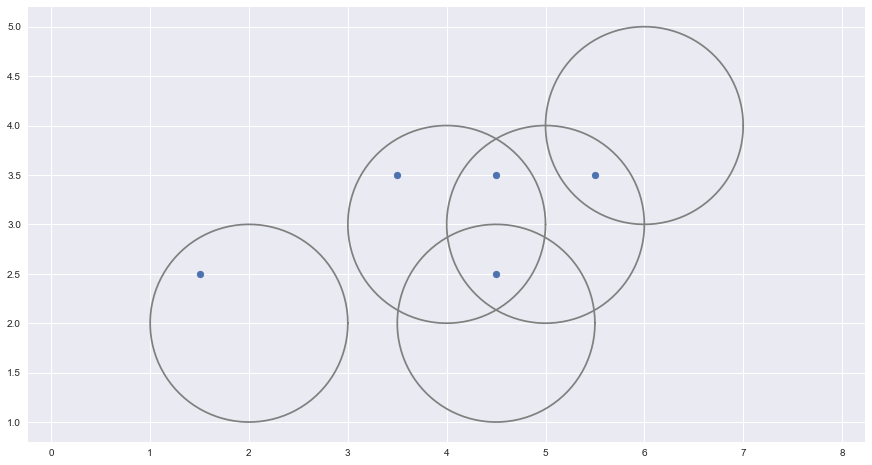

In [57]:
# Visualizing points and disks
def show(P, Q, figsize=(15, 8), colors=None):
    plt.figure(figsize=figsize)
    plt.axis('equal')
    
    # Plot points
    points = np.array(P).reshape((len(P), 2))
    plt.scatter(points[:,0], points[:,1])
    
    # Plot disks
    i = 0
    for disk in Q:
        theta = np.linspace(0, 2*np.pi, 100)
        r = np.sqrt(1.0)
        x1 = r*np.cos(theta) + disk.center[0]
        x2 = r*np.sin(theta) + disk.center[1]
        plt.plot(x1, x2, color='grey' if colors is None else colors[i])
    
        i+=1
    
        
P = [(1.5, 2.5), (3.5, 3.5), (4.5, 2.5), (4.5, 3.5), (5.5, 3.5)]
Q = [Disk((2, 2)), Disk((4, 3)), Disk((4.5, 2)), Disk((5, 3)), Disk((6, 4))]
show(P, Q)

Interation 0
[(0, 0)]
Current node is  (0, 0)
Interation 1
[(1, 1), (0, 0)]
Current node is  (0, 0)
Interation 2
[(1, 1), (1, 3), (0, 0)]
Current node is  (0, 0)
Interation 3
[(1, 1), (1, 3), (1, 1), (0, 0)]
Current node is  (0, 0)
Interation 4
[(1, 1), (1, 3), (1, 1), (1, 3), (0, 0)]
Current node is  (0, 0)
Interation 5
[(1, 1), (1, 3), (1, 1), (1, 3)]
Current node is  (1, 1)
Interation 6
[(1, 3), (1, 1), (1, 3), (2, 5), (1, 1)]
Current node is  (1, 1)
Interation 7
[(1, 3), (1, 3), (2, 5), (1, 1), (2, 4), (1, 1)]
Current node is  (1, 1)
Interation 8
[(1, 3), (1, 3), (2, 5), (2, 4), (1, 1), (2, 3), (1, 1)]
Current node is  (1, 1)
Interation 9
[(1, 3), (1, 3), (2, 5), (2, 4), (2, 3), (1, 1)]
Current node is  (1, 1)
Interation 10
[(1, 3), (1, 3), (2, 5), (2, 4), (2, 3), (2, 5), (1, 1)]
Current node is  (1, 1)
Interation 11
[(1, 3), (1, 3), (2, 5), (2, 4), (2, 3), (2, 5)]
Current node is  (1, 3)
Interation 12
[(1, 3), (2, 5), (2, 4), (2, 3), (2, 5), (2, 6), (1, 3)]
Current node is  (1, 3)

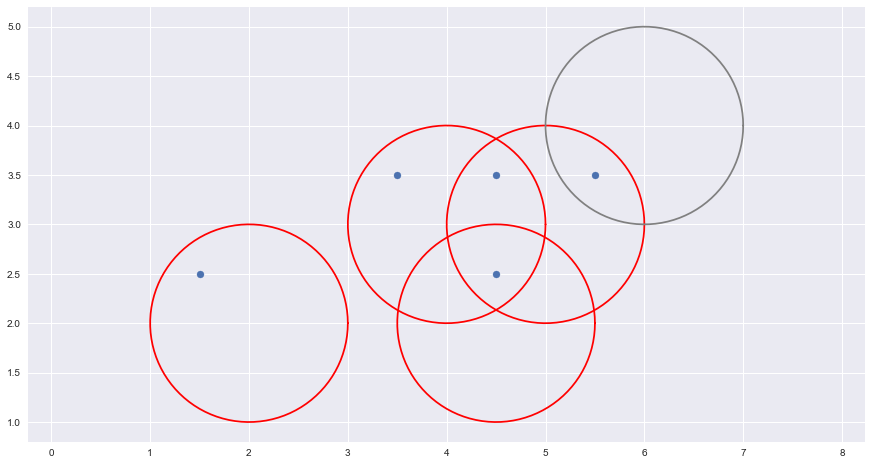

In [69]:
class BBTree:
    
    def __init__(self, P, Q, solution_size=0, nb_covered_points=0):
        self.solution_size = solution_size
        self.nb_covered_points = nb_covered_points
        self.P = P
        self.Q = Q
        self.h_value = self.heuristic()
        self.children = []
#         print(self.solution_size, self.h_value, P, Q)
        
    def set_parent(self, parent):
        self.parent = parent
        
    def add_child(self, child):
        self.children.append(child)
    
    def heuristic(self):
        return self.nb_covered_points  # Number of covered points
    
    def is_realizable(self, best_score):
        # len disks > 0
        return len(self.Q) > 0 and best_score > self.solution_size
    
    def __repr__(self):
        return f'({self.solution_size}, {self.h_value})'
    
    def split(self):
        # Split in order of P
        # Check leaf condition
        if len(self.Q) == 0 or len(self.P) == 0:
            print("Leaf")
            return None
        
        else:
            current_disk = self.Q[0]
            remaining_points = [point for point in self.P if not current_disk.contains(point)]
            left_child = BBTree(remaining_points, self.Q[1:], solution_size=self.solution_size+1, nb_covered_points=self.nb_covered_points+len(P)-len(remaining_points))  # Disk is added to the solution
            right_child = BBTree(self.P, self.Q[1:], solution_size=self.solution_size, nb_covered_points=self.nb_covered_points)  # Disk not added
            return left_child, right_child
            
            
            
def dudc_branch_and_bound(P, Q):
    root = BBTree(P, Q)
    to_visit = [root]
    best_solution_size = 100000
    tree_to_develop = None
    
    i = 0
    while len(to_visit) != 0:
        print("Interation", i)
        i += 1
        print(to_visit)
        
        # Select the best realizable node
        tree_to_develop = to_visit[0]
        for tree in to_visit:
            if tree.h_value < tree_to_develop.h_value:
                tree_to_develop = tree
        print("Current node is ", tree_to_develop)
        to_visit.remove(tree_to_develop)
        
        children = tree_to_develop.split()
        if children is not None:   
            for child in children:
                tree_to_develop.add_child(child)
                to_visit.append(child) if child.is_realizable(best_solution_size) else 0
        elif not tree_to_develop.is_realizable(best_solution_size):
            print("Current node is not realizable")
        else:
            best_solution_size = tree_to_develop.solution_size
                
    print("Returning", tree_to_develop)
    return tree_to_develop

sol_node = dudc_branch_and_bound(P, Q)
sol = [disk for disk in Q if disk not in sol_node.Q]
colors = ['red' if disk not in sol_node.Q else 'grey' for disk in Q]
show(P, Q, colors=colors)